<h1> Lab 3

In [2]:
#Basic packages
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import warnings     #Supress warnings
warnings.filterwarnings("ignore")
#sklearn basics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.inspection import permutation_importance
#GP imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
#other clasical regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
#for Bayesian plotting
from scipy.stats import norm
#handy function to return RMSE
def root_mean_squared_error(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

<h3> Exercise Set 1: Bayesian Updating

Our prior is:
$$
    p(\theta) = \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta_0-\theta)^2} {2\tau_0^2}}
$$
Our single-draw likelihood is:
$$
    p(x_i|\theta) = \frac 1 {\sigma\sqrt{2\pi}}e^{-\frac {(x_i-\theta)^2} {2\sigma^2}}
$$
So our likelihood function is:
$$
    p(x|\theta) = \prod_{i\leq n}p(x_i|\theta) = \left(\frac 1 {\sigma\sqrt{2\pi}}\right)^ne^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$
By Bayes' Theorem this implies our posterior is:
$$
    p(\theta|x) \propto \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta_0-\theta)^2} {2\tau_0^2}}\left(\frac 1 {\sigma\sqrt{2\pi}}\right)^ne^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$
$$
    p(\theta|x) \propto e^{-\frac {(\theta_0-\theta)^2} {2\tau_0^2}}e^{-\frac {\sum_{i}(x_i-\theta)^2} {2\sigma^2}}
$$
$$
    p(\theta|x) \propto e^{-\frac {(\theta_0-\theta)^2} {2\tau_0^2} -\frac {\sum_{i}(x_i-\theta)^2} {2\sigma^2}}
$$
let: 
$$
    \tau_n^2 = \left(\frac n {\sigma^2} + \frac 1 {\tau_0^2}\right)^{-1}
$$
then our posterior can also be rewritten as a normal distribution:
$$
    p(\theta|x) \propto e^{-\frac {(\theta_n-\theta)^2} {2\tau_n^2}}
$$ 
where: 
$$
    \theta_n = \tau_n^2 \left(\frac 1 {\sigma^2}\left(\sum_{i}x_i\right) + \frac {\theta_0} {\tau_0^2}\right)
$$

Given real data $ x = \{2,3,4\}, \theta_0 = 0, \tau_0^2 = 1, \sigma^2 = 1 $
$$
    \tau_n^2 = \left(\frac 3 1 + \frac 1 1\right)^{-1} = \frac 1 4
$$
and
$$
    \theta_n = \frac 1 4 \left((2+3+4) + 0\right) = \frac 9 4

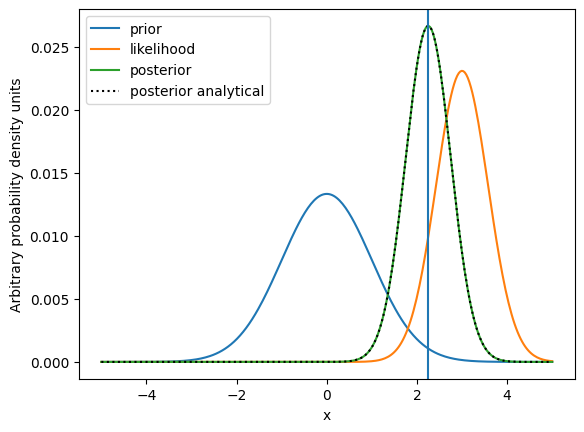

In [3]:
# Exercise Set 1 (c)
def scaleProb(x):
    scaler = 1 / np.sum(x)
    return x * scaler

# get prior graph
x = np.linspace(-5,5,300)
prior = norm.pdf(x, loc=0, scale=1)

# get likelihood graph
draws = [2,3,4]
likelihood = np.ones(x.size)
for i in draws:
    likelihood = likelihood * norm.pdf(x, loc=np.mean(draws), scale=1)

# get posterior graph using bayes theorem and from our analytical solution
posterior = likelihood * prior
posterior2 = norm.pdf(x, loc=9/4, scale=1/2)

# scale probability densities for graphing
prior = scaleProb(prior)
likelihood = scaleProb(likelihood)
posterior = scaleProb(posterior)
posterior2 = scaleProb(posterior2)

# plot all distributions
plt.plot(x, prior, label='prior')
plt.plot(x, likelihood, label='likelihood')
plt.plot(x, posterior, label='posterior')
plt.plot(x, posterior2, label='posterior analytical', linestyle='dotted', color='black')
plt.axvline(9/4)
plt.ylabel('Arbitrary probability density units')
plt.xlabel('x')
plt.legend()
plt.show()

So the Posterior has updated away from our original hypothesis towards the new data.

<h3> Exercise Set 2: Data Preparation

In [18]:
# Exercise Set 2 (a)
url='https://raw.githubusercontent.com/aims-umich/ners590data/main/sparc.csv'
data = pd.read_csv(url)
print(data.head(5))
colnames = data.columns
X = data.values[:,0:6]
Y = data.values[:,6:8]

   Magnetic  PlasmaCurrent  Elongation  Triangularity  Beta  Density       W  \
0      11.5           4.00        1.82           0.49  1.55     15.0  0.0472   
1      11.5           6.50        1.82           0.49  1.30     15.0  0.0350   
2      11.5           5.25        1.89           0.43  0.80     15.0  0.0384   
3      11.5           9.00        1.96           0.37  1.55     15.0  0.0264   
4      11.5           5.25        1.96           0.37  1.55     15.0  0.0369   

        T  
0  3498.5  
1  4988.3  
2  3699.9  
3  4961.6  
4  3335.5  


In [5]:
# Exercise Set 2 (b)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.45, random_state=42)

In [6]:
# Exercise Set 2 (c)
xscaler = MinMaxScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)

yscaler = StandardScaler()
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

<h3> Exercise Set 3: Non-linear Regression

In [7]:
# Exercise Set 3 (a)
dt = DecisionTreeRegressor(min_samples_split=3)
dt.fit(Xtrain, Ytrain)
Ydt=dt.predict(Xtest)

# Exercise Set 3 (b)
rf = RandomForestRegressor(n_estimators=200)
rf.fit(Xtrain, Ytrain)
Yrf=rf.predict(Xtest)

# Exercise Set 3 (c)
gb = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=300))
gb.fit(Xtrain, Ytrain)
Ygb=gb.predict(Xtest)

# Exercise Set 3 (d)

#Define a composite kernel
k = ConstantKernel(constant_value=1) + \
WhiteKernel(noise_level=1) + \
Matern(length_scale=1, nu=1.5)

gp = GaussianProcessRegressor(kernel=k)
gp.fit(Xtrain, Ytrain)
Ygp, Ygpstd=gp.predict(Xtest, return_std=True)

# Exercise Set 3 (e)
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
Ylr=lr.predict(Xtest)

In [8]:
# Exercise Set 3 (f)
def metrics(true, predict):
    return mean_absolute_error(true, predict), mean_absolute_percentage_error(true, predict), r2_score(true, predict), root_mean_squared_error(true, predict)

metdf = pd.DataFrame(np.column_stack((metrics(Ytest, Ydt), metrics(Ytest, Yrf), metrics(Ytest, Ygb), \
                    metrics(Ytest, Ygp), metrics(Ytest, Ylr))), index=['MAE', 'MAPE', 'R2', 'RMSE'], \
                    columns = ['Decision Tree', 'Random Forest', 'Gradient Boosting', \
                               'Gaussian Process', 'Linear Regression'])

""" metdfW = pd.DataFrame(np.column_stack((metrics(Ytest[0], Ydt[0]), metrics(Ytest[0], Yrf[0]), metrics(Ytest[0], Ygb[0]), \
                    metrics(Ytest[0], Ygp[0]), metrics(Ytest[0], Ylr[0]))), index=['MAE', 'MAPE', 'R2', 'RMSE'], \
                    columns = ['Decision Tree', 'Random Forest', 'Gradient Boosting', \
                               'Gaussian Process', 'Linear Regression'])
metdfT = pd.DataFrame(np.column_stack((metrics(Ytest[1], Ydt[1]), metrics(Ytest[1], Yrf[1]), metrics(Ytest[1], Ygb[1]), \
                    metrics(Ytest[1], Ygp[1]), metrics(Ytest[1], Ylr[1]))), index=['MAE', 'MAPE', 'R2', 'RMSE'], \
                    columns = ['Decision Tree', 'Random Forest', 'Gradient Boosting', \
                               'Gaussian Process', 'Linear Regression'])
print(metdfW)
print(metdfT) """

print(metdf)

      Decision Tree  Random Forest  Gradient Boosting  Gaussian Process  \
MAE        0.094826       0.079909           0.163148          0.139523   
MAPE       0.997754       0.814463           1.184095          1.247132   
R2         0.939191       0.962279           0.894407          0.925294   
RMSE       0.217501       0.170094           0.276157          0.234489   

      Linear Regression  
MAE            0.323273  
MAPE           2.401699  
R2             0.684505  
RMSE           0.481224  


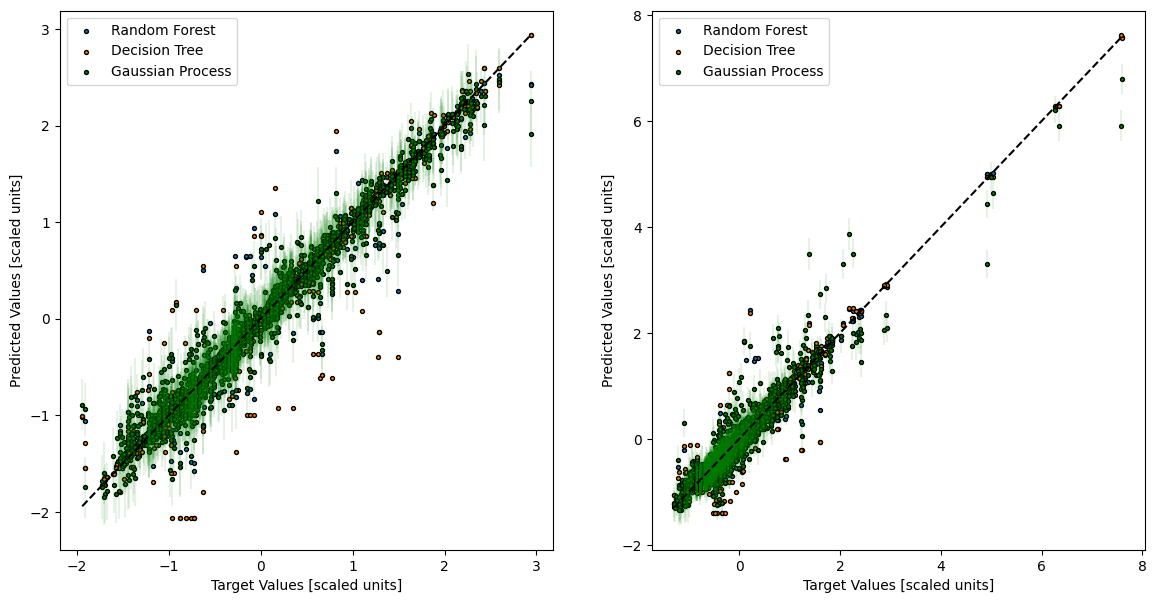

In [10]:
# Exercise Set 3 (g)
fig, ax = plt.subplots(1,2, figsize=(14,7))
for i in [0,1]:
    ax[i].scatter(Ytest[:,i], Yrf[:,i], label="Random Forest", edgecolor='black', s=8)
    ax[i].scatter(Ytest[:,i], Ydt[:,i], label="Decision Tree", edgecolor='black', s=8)
    ax[i].scatter(Ytest[:,i], Ygp[:,i], label="Gaussian Process", s=8, color='g', edgecolor='black')
    ax[i].errorbar(Ytest[:,i], Ygp[:,i], yerr=Ygpstd[:,i], fmt="o", color='g', alpha=0.1, markersize=0)
    ax[i].legend()
    ax[i].set_xlabel("Target Values [scaled units]")
    ax[i].set_ylabel("Predicted Values [scaled units]")
    ax[i].plot([min(Ytest[:,i]), max(Ytest[:,i])], [min(Ytest[:,i]), max(Ytest[:,i])], color='black', linestyle='--')

plt.show()

**Exercise Set 3 (h)** 

Of the models, the ranking from best to worst (by $ R^2 $ value) was: Random Forest, Decision Tree, Gaussian Process, Gradient Boosting, then Linear Regression. Of note, the Gaussian Process model was horrible at predicting Pedestal Temperature ( $ R^2 = -0.321352 $ ) but great at predicting Pedestal Width ( $ R^2 = 0.999596 $ ). In fact, all models were better at predicting width than temperature, with the only model that had $ R^2 > 0.9 $ for temperature being the Random Forest model.

The Gaussian Process predicted a mean width of -0.00558 (scaled width units) with a standard deviation of 0.2815 (also scaled width units). To evaluate if this is close enough, we can count what percentage of the time our test data was within different standard deviations of the predicted value. If the model was accurate, we should expect $ \approx 68\%, 95\% $ and $ 99.7\% $ for 1, 2, and 3 standard deviations respectively. 

In [12]:
boolArray = np.logical_and(Ygp + Ygpstd > Ytest, Ygp - Ygpstd < Ytest)
print(np.sum(boolArray) / boolArray.size, "percent of data was within 1 std.")
boolArray = np.logical_and(Ygp + Ygpstd * 2 > Ytest, Ygp - Ygpstd * 2 < Ytest)
print(np.sum(boolArray) / boolArray.size, "percent of data was within 2 stds.")
boolArray = np.logical_and(Ygp + Ygpstd * 3 > Ytest, Ygp - Ygpstd * 3 < Ytest)
print(np.sum(boolArray) / boolArray.size, "percent of data was within 3 stds.")

0.854628921193573 percent of data was within 1 std.
0.9628921193573068 percent of data was within 2 stds.
0.9877582249426167 percent of data was within 3 stds.


So we can conclude that our gaussian process performed fairly well, since it overperformed in the 1 standard deviation range and underperformed in the 3 standard deviation range. 

**Exercise Set 3 (i)**

First time how long our predictions take. 

In [13]:
Ygp, Ygpstd=gp.predict(Xtest, return_std=True)

According to the built in Python-notebook timer, the prediction from our surrogate model took 1.2 seconds to perform 1307 simulations. This means for 1000 sims, our model would take:
$$
    \frac {1.2\text{ seconds}} {1,307\text{ sims}} * {1000\text{ sims}} = 0.918\text{ seconds}
$$
and EPED would take:
$$
    45\text{ hours}* \frac {3,600\text{ seconds}} {1\text{ hour}} * 1,000\text{ sims} = 162,000,000\text{ seconds}
$$ 
giving us an acceleration factor of:
$$
    \frac {162,000,000\text{ seconds}} {0.918\text{ seconds}} = 176,000,000
$$
so yes, I do indeed see the benefit of the surrogate model when doing design optimization when many iterations through the expensive simulation model are needed. :)

<h3> Exercise Set 4: Cross Validation and Feature Importance

<Axes: >

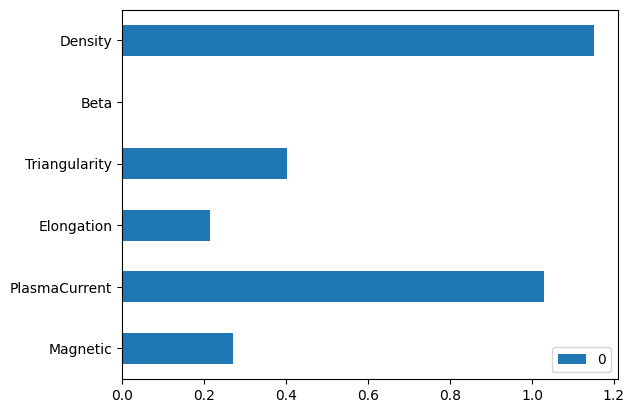

In [22]:
# Exercise Set 4 (a)
perm= permutation_importance(estimator=rf, X=Xtest, y=Ytest, n_repeats=10, random_state=42)
perm_imp=pd.DataFrame(perm.importances_mean, index=['Magnetic', 'PlasmaCurrent', 'Elongation', \
                                                    'Triangularity', 'Beta',  'Density'])
perm_imp.plot(kind='barh')

<Axes: >

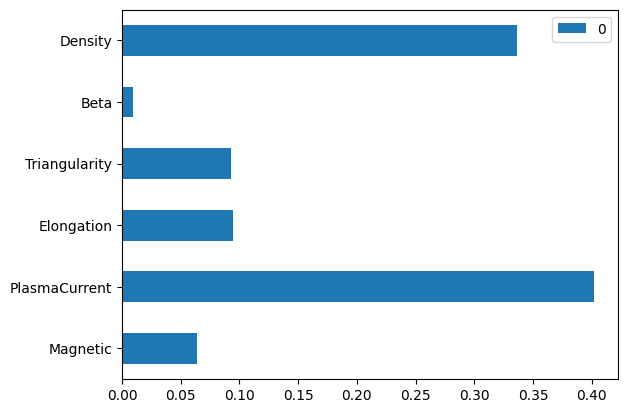

In [25]:
features = rf.feature_importances_ 
features_imp=pd.DataFrame(features, index=['Magnetic', 'PlasmaCurrent', 'Elongation', \
                                                    'Triangularity', 'Beta',  'Density'])
features_imp.plot(kind='barh')

There is a slight discrepency in the importance of the different features. In both cases, the most important features were Density and Plasma Current, but which is #1 varies. 

In [31]:
# Exercise Set 4 (b)
rfcv = RandomForestRegressor(n_estimators=200)

fivefold = cross_val_score(estimator=rfcv, X=Xtest, y=Ytest, scoring='r2')
print(fivefold)

tenfold = cross_val_score(estimator=rfcv, cv=10, X=Xtest, y=Ytest, scoring='r2')
print(tenfold)

[0.96034511 0.89843175 0.94187591 0.92121153 0.96162838]
[0.95542712 0.97179062 0.91090601 0.91428258 0.90847225 0.96255451
 0.96434855 0.93390156 0.97950462 0.93850626]


There is some discrepency depending on how the data is split for training and testing, since the R^2 scores can range from between .898 and .962. Interestingly, the five-fold split shows larger discrepencies than the 10-fold split does. 